# **Modeling and Evaluation**

## Objectives

* Here, we basically run a 2nd version of our model
* We mainly use the same steps of the previous notebook BUT we change (switch off) the SmartCorrelatedSelection threshold to include all features
* Fit and evaluate the ML pipeline to predict attrition

## Inputs

* Raw dataset in outputs/datasets/collection/employee-attrition.csv

## Outputs

* TrainSet and TestSet
* Data cleaning and feature engineering pipeline
* Modeling pipeline

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspace/attrition-predictor'

---

# Load the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
df = (pd.read_csv(f"outputs/datasets/collection/employee-attrition.csv")
        .drop(labels=['DailyRate','EmployeeCount', 'EmployeeNumber', 'HourlyRate',
                      'MonthlyRate', 'StandardHours', 'Over18'], axis=1))

df['Attrition'] = df['Attrition'].replace({"Yes":1, "No":0})

df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,4,1,6,3,3,2,2,2,2


Next, we will create:
* Split the dataset
* Data cleaning and feature engineering pipeline
* Handle imbalance
* Modeling pipeline

---

# Split the dataset

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Attrition'], axis=1),
                                                    df['Attrition'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                   )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1176, 27) (1176,) (294, 27) (294,)


---

## ML Pipeline 1: Data cleaning and feature engineering pipeline

We create the datacleaning and feature engineering pipeline based on the conclusions from the last notebook. Here, we use a threshold for `SmartCorrelatedSelection` of 1.0 instead of 0.6.

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('yj', vt.YeoJohnsonTransformer(variables=['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']) ),
        ('OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BusinessTravel', 'Department',
                                                                'EducationField','Gender', 'JobRole',
                                                                'MaritalStatus', 'OverTime'])),

        ('SmartCorrelatedSelection', SmartCorrelatedSelection(method="spearman",
                                                                threshold=1.0,
                                                                selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('yj',
                 YeoJohnsonTransformer(variables=['MonthlyIncome',
                                                  'TotalWorkingYears',
                                                  'YearsAtCompany'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BusinessTravel', 'Department',
                                           'EducationField', 'Gender',
                                           'JobRole', 'MaritalStatus',
                                           'OverTime'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=1.0))])

### Fit the pipeline

In [6]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# check that a categorical variable has been transformed to numerical
X_train['Gender']

(1176, 27) (1176,) (294, 27) (294,)


1374    0
1092    1
768     1
569     1
911     1
       ..
763     0
835     1
1216    1
559     1
684     1
Name: Gender, Length: 1176, dtype: int64

As we can see, no features were dropped. The smart correlation selection was basically switched off. Let's see how this will affect our model performance.

In [7]:
pipeline_data_cleaning_feat_eng['SmartCorrelatedSelection'].features_to_drop_

[]

---

# Handle imbalance

Recap on the target imbalance mentioned in notebook 02. There is more 'No attrition' or 0's than 'Yes attrition' or 1's.

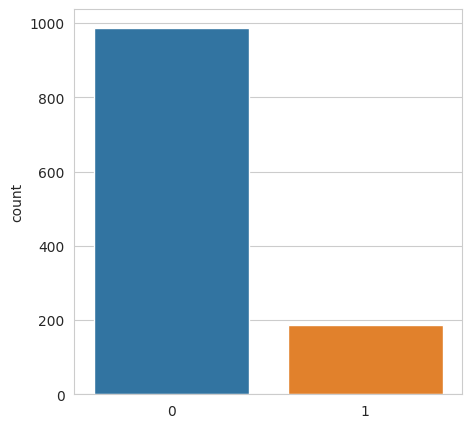

In [8]:
attrition_array = y_train.to_numpy()

def plot_target_count(target):
    fig, axes = plt.subplots(figsize=(5,5))
    sns.countplot(x = target)
    plt.show()

plot_target_count(attrition_array)

We will use Synthetic Minority Over-sampling Technique (SMOTE) from the `imblearn` library. The sampling strategy will be `minority` so it resamples all classes except the majority.

In [9]:
from imblearn.over_sampling import SMOTE

smote_over = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = smote_over.fit_resample(X_train, y_train)

We plot once again to check after SMOTE operation.

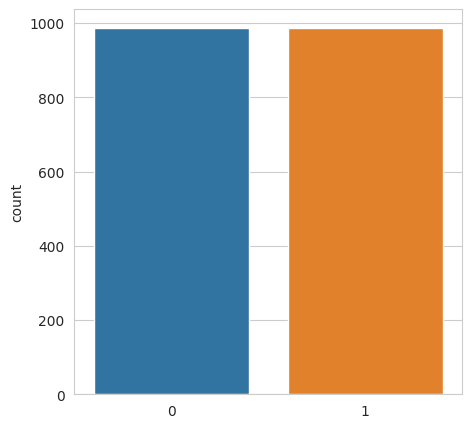

In [10]:
attrition_array_balanced = y_train.to_numpy()
plot_target_count(attrition_array_balanced)

And we notice that the traget is now balanced. One has to mind that we changed the dataset for the benefit of fitting a better model.

---

## ML Pipeline2: Modelling and Hyperparameter Optimisation pipeline

Here, the pipeline consists of:
* **StandardScaler**: to rescale the features to have standard normal distribution with zero mean and standard deviation of 1. It is performed on all variables. The variable distribution might be slightly different.
* **SelectFromModel**: to select the relevant features for fitting. We use the embedded method to perform feature selection during training. The model will be the algorithm of our choice.
* **model**: the ML algorithm

In [11]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler
# Feat Selection
from sklearn.feature_selection import SelectFromModel
# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Grid search Cross Validation

We use the custom python class for hyperparameter optimization provided by CI.

In [12]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:
    """
    Custom class provided by CI
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

We test multiple classifier models (regression and tree algorithms) with their default hyperparameters. After we decide on the best performing algorithm, we can then run the algorithm with multiple hyperparameters and pick the best performing hyperparameters. We will end up with the best performing algorithm and hyperparameters.

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Fit the pipeline to the TrainSet data. We set cross validation `cv` to 5 and we use all processors or threads by setting `n_jobs` to -1.

In [14]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Get the performance summary

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.550505,0.864544,0.969543,0.157714
4,GradientBoostingClassifier,0.510101,0.854422,0.969697,0.173089
5,ExtraTreesClassifier,0.494949,0.853397,0.964467,0.180729
6,AdaBoostClassifier,0.449495,0.845357,0.974619,0.198627
0,LogisticRegression,0.464646,0.828124,0.939394,0.182664
2,DecisionTreeClassifier,0.424242,0.806855,0.944162,0.194317
1,XGBClassifier,0.479798,0.77645,0.90404,0.152476


The best performing algorithm is (like the last notebook) `RandomForestClassifier` with an average recall on `Attrition` of 0.86. Also `GradientBoostingClassifier` came in 2nd place with mean score of 0.85, however this time instead of `DecisionTreeClassifier`, we have `ExtraTreesClassifier` scoring 0.85.

Next, we perform an extensive study on 4 hyperparameter configurations for each of our best 3 performing algorithms.

From RandomForestClassifier [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* It is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. We chose to tune the following parameters:
    - n_estimators: The number of trees in the forest. Default: 100
    - max_depth: The maximum depth of the tree (regression estimator). It limits the number of nodes in the tree. Default: 3
    - min_samples_split: The minimum number of samples required to split an internal node. Default:2
    - max_samples: The number of samples to draw from X to train each base estimator. Default: None

From GradientBoostingClassifier [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* It builds an additive model in a forward stage-wise fashion and allows for the optimization of arbitrary differentiable loss functions. The parameters to tune are:
    - n_estimators: The number of boosting stages to perform. Default: 100
    - max_depth
    - min_samples_split
    - min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Default: 0

From ExtraTreeClassifier [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
* It implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset. The parameters used are the same as GradientBoostingClassifier.



In [16]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}

params_search = {
    "RandomForestClassifier":{
        'model__n_estimators': [10, 100, 1000], 
        'model__max_depth': [3, 30, 300],
        'model__min_samples_split': [2, 10, 100],
        'model__max_samples': [10, 100, None],
    },
    "GradientBoostingClassifier": {
        'model__n_estimators': [10, 100, 1000], 
        'model__max_depth': [3, 30, 300],
        'model__min_samples_split': [2, 10, 100],
        'model__min_weight_fraction_leaf': [0.0, 0.3, 0.5],
    },
    "ExtraTreesClassifier": {
        'model__n_estimators': [10, 100, 1000],
        'model__max_depth': [3, 30, 300],
        'model__min_samples_split': [2, 10, 100],
        'model__min_weight_fraction_leaf': [0.0, 0.3, 0.5],
    },
}

In [17]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_samples,model__min_samples_split,model__n_estimators,model__min_weight_fraction_leaf
83,GradientBoostingClassifier,0.5,0.875686,0.974747,0.187927,3,NaN,2,1000,0.0
101,GradientBoostingClassifier,0.479798,0.874691,0.979695,0.197509,3,NaN,100,1000,0.0
92,GradientBoostingClassifier,0.474747,0.871645,0.979798,0.198564,3,NaN,10,1000,0.0
127,GradientBoostingClassifier,0.484848,0.868605,0.974747,0.191987,30,NaN,100,100,0.0
154,GradientBoostingClassifier,0.484848,0.8686,0.979798,0.192065,300,NaN,100,100,0.0
...,...,...,...,...,...,...,...,...,...,...
34,RandomForestClassifier,0.0,0.0,0.0,0.0,30,10,100,100,NaN
35,RandomForestClassifier,0.0,0.0,0.0,0.0,30,10,100,1000,NaN
8,RandomForestClassifier,0.0,0.0,0.0,0.0,3,10,100,1000,NaN
7,RandomForestClassifier,0.0,0.0,0.0,0.0,3,10,100,100,NaN


In [19]:
best_model = grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_

print(f'Best model is: {best_model} \nBest parameters are: {best_parameters}')

Best model is: GradientBoostingClassifier 
Best parameters are: {'model__max_depth': 3, 'model__min_samples_split': 2, 'model__min_weight_fraction_leaf': 0.0, 'model__n_estimators': 1000}


We see that this time `GradientBoostingClassifier` is the best performing algorithm.

Grab the pipeline

In [20]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model',
                 GradientBoostingClassifier(n_estimators=1000,
                                            random_state=0))])

### Assess feature importnace

Show the features considered important for the given dataset using a certain algorithm

In [21]:
print(X_train.columns[pipeline_clf['feature_selection'].get_support()])
print(pipeline_clf['model'].feature_importances_)

Index(['Age', 'Department', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'OverTime', 'StockOptionLevel',
       'YearsAtCompany'],
      dtype='object')
[0.10507922 0.07868563 0.07886067 0.0524364  0.10412245 0.06592053
 0.30417588 0.06499171 0.14572751]


* These are the 9 most important features in descending order. The model was trained on them: 
['OverTime', 'YearsAtCompany', 'Age', 'JobLevel', 'EnvironmentSatisfaction', 'Department', 'JobSatisfaction', 'StockOptionLevel', 'JobInvolvement']


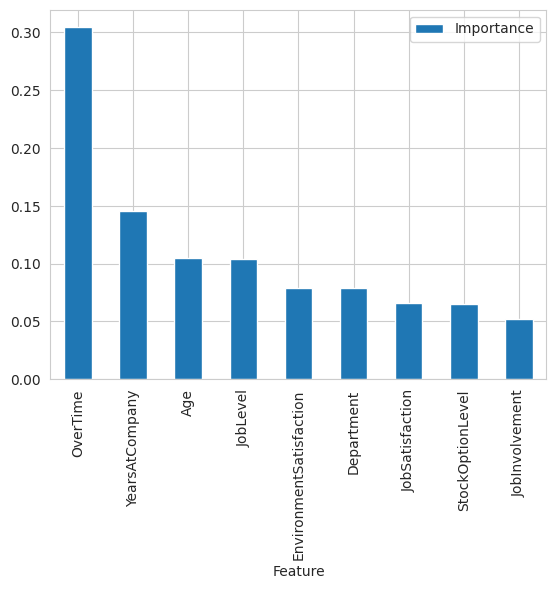

In [22]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feature_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

sns.barplot(data=df_feature_importance, x="Feature", y="Importance")
plt.xticks(rotation=90)

From the 27 features, we end up with 9 important features with `OverTime` being the variable that strongly affects the target. We will use all 9 features for refitting the model. But first we evaluate the current pipeline.

---

## Evaluate the pipeline

In [23]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [24]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Attrition', 'Attrition'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                        Actual No Attrition Actual Attrition
Prediction No Attrition                 983               20
Prediction Attrition                      5              968


---  Classification Report  ---
              precision    recall  f1-score   support

No Attrition       0.98      0.99      0.99       988
   Attrition       0.99      0.98      0.99       988

    accuracy                           0.99      1976
   macro avg       0.99      0.99      0.99      1976
weighted avg       0.99      0.99      0.99      1976
 

#### Test Set ####

---  Confusion Matrix  ---
                        Actual No Attrition Actual Attrition
Prediction No Attrition                 222               26
Prediction Attrition                     23               23


---  Classification Report  ---
              precision    recall  f1-score   support

No Attrition       0.90      0.91      0.90       245
   Attrition       0.50      0.4

Compared to the pipeline from the last notebook (version 1), we see an improvement in the precision and accuracy on both the train and test sets.

Additionally, we see that most of the model success metrics are met. These were:
* A minimum of 80% no-attrition on train and test datasets, here we get 98% and 90%, respectively
* A minimum of 60% attrition on train and test datasets, here we get 99% and 50%, respectively
* Note that the attrition prediction still does not meet the requirements (10% below). Ideally, further iterations with other models and hyperparameters can be tested. However, due to time limitation of the project, we will not proceed with further iterations.

Next step, we refit the pipeline only with the most important 9 features.

---

## Dump the model pipeline

In [28]:
import joblib

version = 'v2'
file_path = f'outputs/ml_pipelines/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipelines/v2'


Save the train and test datasets

In [29]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Dump the pipelines to pickle files

In [30]:
# Save the data cleaning and feature engineering pipeline
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")
# Save the modeling pipeline
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipelines/v2/clf_pipeline_model.pkl']

Feature importance was one of the business requirement, therefore, we plot it and save the file.

In [1]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

NameError: name 'df_feature_importance' is not defined

---

# Conclusions

* By switching off the smart correlation selection, we retained all variables and with that got a better performing ML pipeline.
* The pipeline relies on the `GradientBoostClasifier` and it meets most of the success metrics